In [1121]:
## CE 295 - Energy Systems and Control
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd
from scipy import interp
from scipy.interpolate import RegularGridInterpolator
import time
import sqlite3
import itertools
import pandas as pd
from scipy.interpolate import interp1d

## THE DATA

In [1123]:
PATH_DATA = 'C:\\Users\\admin\\Desktop\\energy_latest/data/'
PATH_REPORT = 'C:\\Users\\admin\\Desktop\\energy_latest/report/'
data = pd.read_csv('C:\\Users\\admin\\Desktop\\energy_project_v0\\data\\price_demand.csv')
data.max()

Year       2015.000
Month        12.000
day          31.000
Hour         24.000
Demand    23169.960
Price       187.891
dtype: float64

Text(0.5,1,u'Distribution of the prices of electricity vs time for several days')

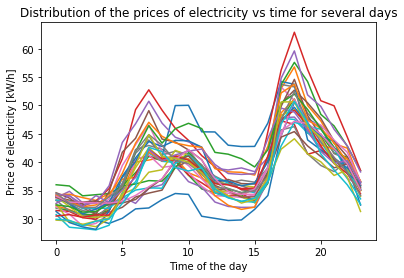

In [1108]:
for day in range(1, 31):
    for month in range(1, 2):
        plt.plot(range(0, 24), data[(data['day'] == day) & (data['Month'] == month) & (data['Year'] == 2013)]['Price'])
plt.xlabel('Time of the day')
plt.ylabel('Price of electricity [kW/h]')
plt.title('Distribution of the prices of electricity vs time for several days')

# Regular model using CVX

In [1109]:
## SET PARAMETERS
num_station = 2     #This can be changed without changing the code below
ns = 10

N = 24 # Time Horizon
c = 100
alpha = 0.003
delta_t = 10./N
delta_t


0.4166666666666667

In [1110]:
## GET DATA
prices_day = data[(data['day'] == 1) & (data['Month'] == 1) & (data['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
prices1 = np.flip(prices_interp(np.linspace(0, 23, N)), axis=0)
prices2 = prices_day


## Presence and X_init

In [1111]:
# ----------------------- INITIAL SOC --------------------------------
X_init=np.zeros((num_station, N+1))
# X_init[:,0]=np.array([0.1,0.2,0.3]) #np.random.random((num_station))
X_init[0:num_station,0]=np.array([0.2,0.3]) #np.random.random((num_station))
X_init[0,13]=0.2
X_init[1,16]=0.3


print X_init
# ---------------------- INDEX OF ELEMENTS SOC_INIT DIFFERENT OF 0 ----
X_index = np.array(np.nonzero(X_init))
print X_index

[[ 0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2  0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.3  0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0  0  1  1]
 [ 0 13  0 16]]


In [1112]:
presence=np.ones((num_station, N+1))

presence[0,-10:]=0
presence[0,:4]=0
presence[1,-5:]=0
print presence

presence[0, :] = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
presence[1, :] = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

p_index = np.argwhere(presence== 0)
# print p_index



for a in range(int(p_index.shape[0])):
    i=p_index[a,0]
    j=p_index[a,1]
    presence[i,j]
#     print i,j,presence[i,j]



[[ 0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  0.  0.  0.  0.  0.]]


In [1113]:
c=1.5
def satisfaction_function(x):
    return c * (1 - power(np.exp(1),(alpha * (1 - x))) )/(1 - power(exp(1),alpha))

0.401000022888 seconds
The tota cost is  123.177851985 USD


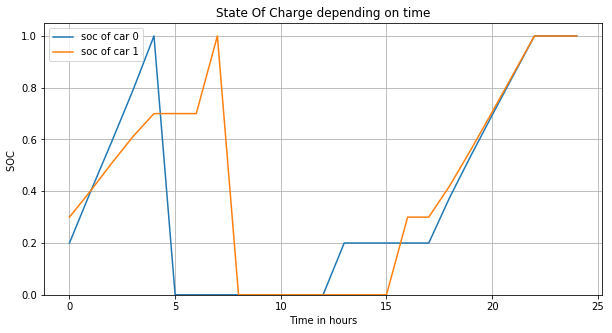

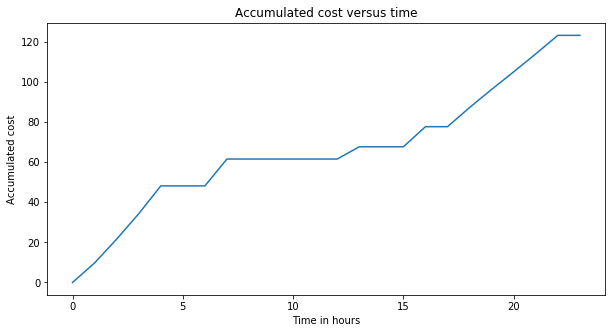

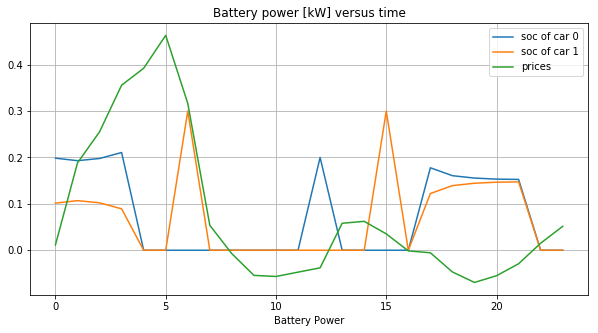

In [1132]:
#---------------------------------- WITH PRESENCE ---------------------------------------
# Solve with CVXPY
import cvxpy
start = time.time()

u_max=0.3
beta=200
prices=prices1

# Define optimization vars
u = Variable(num_station,N)
SOC = Variable(num_station,N+1)
pres= Bool(num_station,N+1)

# Define objective function
cost = 0
constraints = []

for t in range(N):
    constraints += [(sum_entries(u[:, t])) <= u_max]
    for s in range(num_station):
        cost+= u[s,t]*prices[t] 
        constraints += [pres[s, t] == presence[s,t]]
        constraints += [u[s, t] >= 0 , u[s, t] <= 1- SOC[s, t]]
        constraints += [SOC[s, t] >=0, 1 >= SOC[s, t]]
        
        if (presence[s,t+1]==0):
            constraints += [SOC[s, t+1] == 0]
        else:
            constraints += [SOC[s, t+1] == (SOC[s, t] + u[s, t])]
        if (presence[s,0]==0):
            constraints += [SOC[s, 0] == 0]


constraints += [SOC[0, -1] == 1]
constraints += [SOC[1, -1] == 1]

constraints += [SOC[0, 4] == 1]
constraints += [SOC[1, 7] == 1]

# constraints += [SOC[2, -1] == 1]
# constraints += [SOC[1, 19] == 0.8]


#Constraining to the initial value of 
for a in range(int(X_index.shape[1])):
    i=X_index[0,a]
    j=X_index[1,a]
    constraints += [SOC[i,j]==X_init[i,j]]
    
# MAXIMUM ENERGY CONSTRAINT
# for s in range(num_station):   
#     cost+= beta*(1-SOC[s,N])
    
# MAXIMUM SOC AT END OF HORIZON
     

prob2 = cvxpy.Problem(cvxpy.Minimize(cost), constraints)


# Define problem and solve
prob2.solve()
sol=SOC.value
sol_u=u.value
# print sol
# print sol_u
# DP Timer
# print sol
J_sim = np.zeros((N))
for t in range(N):
    J_sim[t] = prices[t] * np.sum(sol_u[:, t])
# DP Timer
end = time.time()
print(str(end - start) + " seconds")
print 'The tota cost is ', J_sim.sum(), 'USD'
# =======================================================================================
# ---------------------------------PLOT--------------------------------------------------
# ========================================================================================


fig=plt.figure()
plt.figure(figsize=(10, 5))
for i in range(num_station):
    plt.plot(range(N+1), sol[i, :].T, label='soc of car '+str(i))
    
# plt.plot(range(N), prices[:N]/max(prices), label='prices')
plt.ylim((0, 1.05))
plt.legend()
plt.xlabel('Time in hours')
plt.title('State Of Charge depending on time')
plt.ylabel('SOC ')
plt.grid()
plt.savefig(PATH_REPORT + 'soc1.png')
#plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(N), [np.sum(J_sim[:k]) for k in range(0, N)])  # plot speed
plt.title('Accumulated cost versus time')
plt.xlabel('Time in hours')
plt.ylabel('Accumulated cost')


fig=plt.figure()
plt.figure(figsize=(10, 5))
for i in range(num_station):
    plt.plot(range(N), sol_u[i, :].T, label='soc of car '+str(i))
plt.plot(range(N), prices/40 - 0.8, label='prices')

plt.title('Battery power [kW] versus time')
plt.legend()
plt.xlabel('Time in hours')
plt.xlabel('Battery Power')
plt.grid()
plt.savefig(PATH_REPORT + 'u1.png')
plt.show()

In [1137]:
# ----------------------- INITIAL SOC --------------------------------
X_init=np.zeros((num_station, N+1))
X_init[:,0]=np.array([0.3,0.1,0.5]) #np.random.random((num_station))
# X_init[1:num_station,0]=np.array([0.2,0.3]) #np.random.random((num_station))

print X_init
# ---------------------- INDEX OF ELEMENTS SOC_INIT DIFFERENT OF 0 ----
X_index = np.array(np.nonzero(X_init))
print X_index

[[ 0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[0 1 2]
 [0 0 0]]


In [1138]:
# WITHOUT PRESENCE 
start = time.time()
# Solve with CVXPY
import cvxpy
num_station=3
u_max=0.2
beta= 30
prices=prices1

# Define optimization vars
u = Variable(num_station,N)
SOC = Variable(num_station,N+1)

# Define objective function
cost = 0
constraints = []

for t in range(N):
    constraints += [sum_entries(u[:, t]) <= u_max]
    for s in range(num_station):
        constraints += [SOC[s, t+1] == (SOC[s, t] + u[s, t])]
        cost+= u[s,t]*prices[t] 
    constraints += [u[:, t] >= 0, u[:, t] <= 1 - SOC[:, t]]
    constraints += [SOC[:, t] >= 0, 1 >= SOC[:, t] ]
    
#Constraining to the initial value of 
for a in range(int(X_index.shape[1])):
    i=X_index[0,a]
    j=X_index[1,a]
    constraints += [SOC[i,j]==X_init[i,j]]
    
    
# MAXIMUM SOC AT END OF HORIZON
constraints +=[SOC[:,-1]==1]     

prob2 = cvxpy.Problem(cvxpy.Minimize(cost), constraints)


# Define problem and solve
prob2.solve()
sol=SOC.value
sol_u=u.value

# print sol
J_sim = np.zeros((N))
for t in range(N):
    J_sim[t] = prices[t] * np.sum(sol_u[:, t])
# DP Timer
end = time.time()
print(str(end - start) + " seconds")
print 'The tota cost is ', J_sim.sum(), 'USD'


0.184000015259 seconds
The tota cost is  63.9187799982 USD


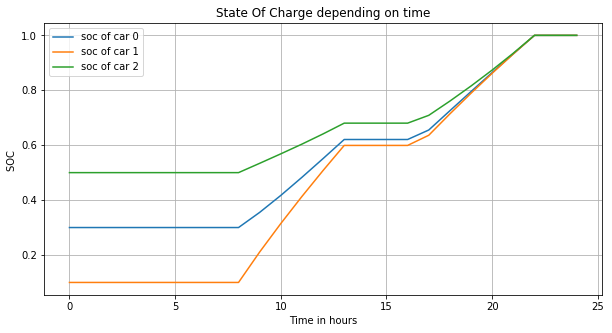

In [1140]:
# =======================================================================================
# ---------------------------------PLOT--------------------------------------------------
# ========================================================================================
## Plot Simulation Results
fig=plt.figure()
plt.figure(figsize=(10, 5))
for i in range(num_station):
    plt.plot(range(N+1), sol[i, :].T, label='soc of car '+str(i))
# plt.plot(range(N), prices[:N]/max(prices), label='prices')
plt.legend()
plt.xlabel('Time in hours')
plt.title('State Of Charge depending on time')
plt.ylabel('SOC ')
plt.grid()
plt.savefig(PATH_REPORT + 'soc_nopres_1.png')
plt.show()
# SOC versus time

Text(0,0.5,u'Accumulated cost')

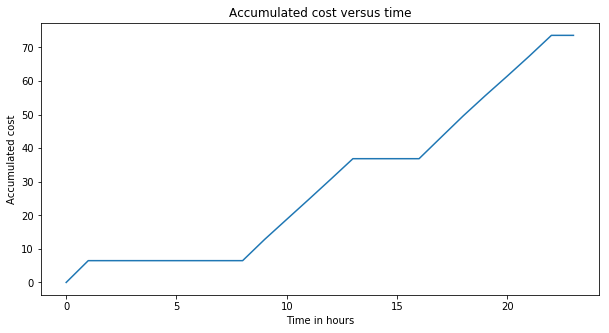

In [1033]:
plt.figure(figsize=(10, 5))
plt.plot(range(N), [np.sum(J_sim[:k]) for k in range(0, N)])  # plot speed
plt.title('Accumulated cost versus time')
plt.xlabel('Time in hours')
plt.ylabel('Accumulated cost')

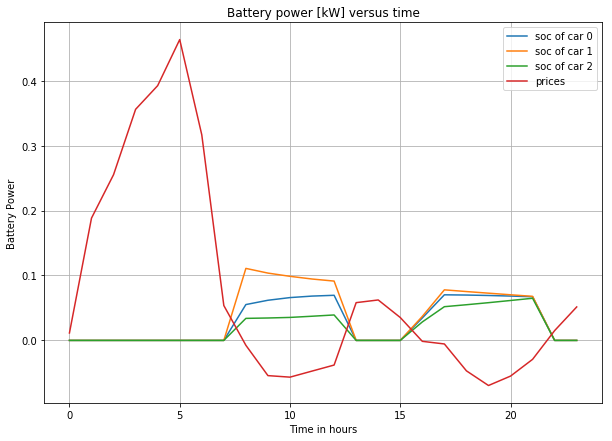

In [1142]:
fig=plt.figure()
plt.figure(figsize=(10, 7))
for i in range(num_station):
    plt.plot(range(N), sol_u[i, :].T, label='soc of car '+str(i))
plt.plot(range(N), prices[:N]/40-0.8, label='prices')
plt.title('Battery power [kW] versus time')
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('Battery Power')
plt.grid()
plt.savefig(PATH_REPORT + 'u_nopres1.png')
plt.show()